# Basic plotting of geospatial data

In [1]:
# Ensuring high resolution plots from mac device
%config InlineBackend.figure_format = 'retina'

## Plotting vector data
Vector data are data represented by a series of vertices, sometimes connected by edges. You typically have 4 types:
1. Points. Single vertices (e.g. a latitude and longitude coordinate pair that represents the location of an ATM machine)
2. Lines. Sets of vertices that are connected by edges (e.g. 3 latitude/longitude pairs that define the location of  a road).
3. Polygons. Sets of vertices connected by edges where the last vertex and the first vertex are the same (e.g. 4 latitude/longitude pairs that define the outline of a building)
4. Multi-polygons. A collection of polygons (e.g. a university represented as a collection of polygon buildings or a building with an inner courtyard defined by an outer and inner polygon)

In this example, we'll start by walking through how to plotpolygons representing a grid accross the state of Connecticut.

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.features import rasterize

plt.close('all')

<AxesSubplot:>

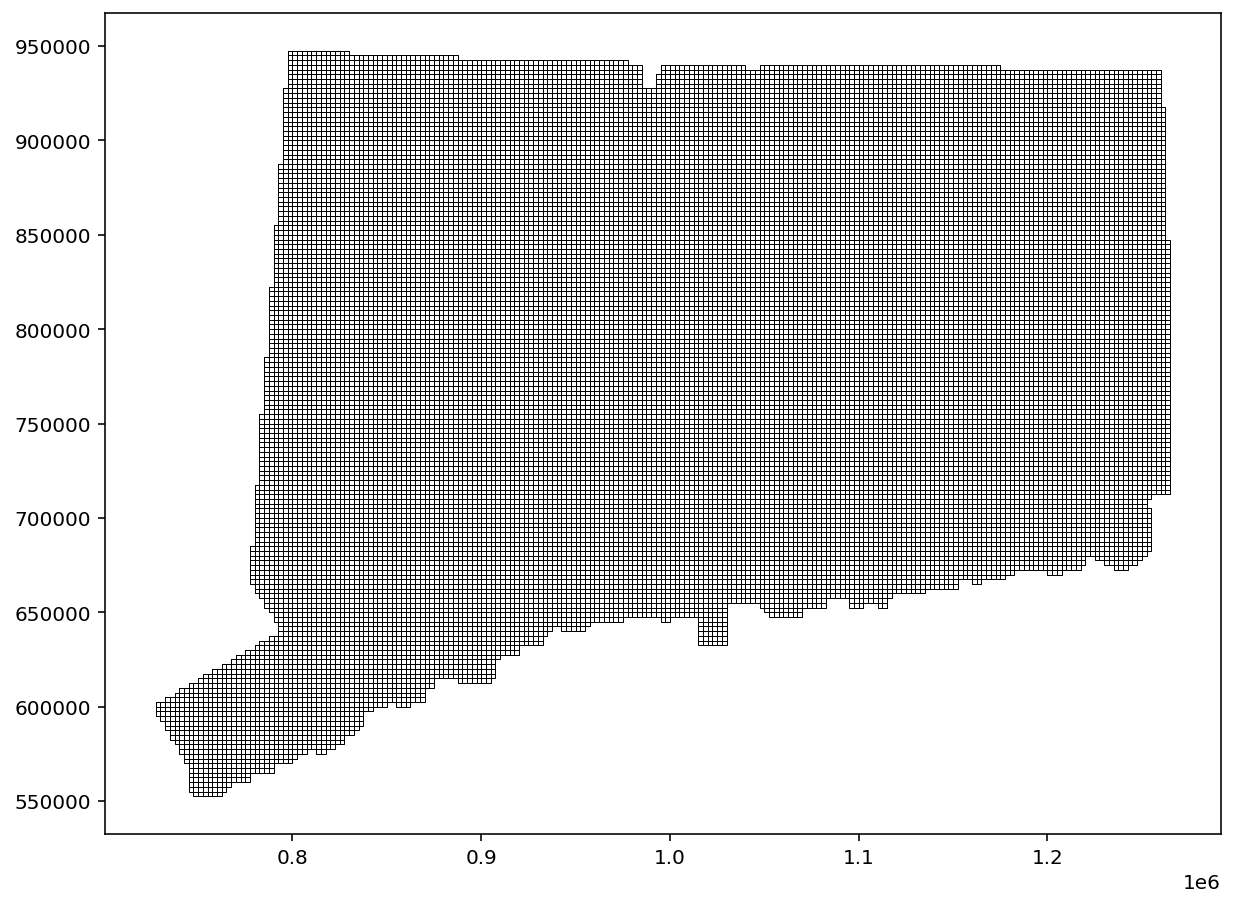

In [6]:
fig, ax = plt.subplots(num='main', figsize=(10,10))

data_path = "./data/DeliveryGrid2016/DeliveryGrid.shp"

# Plot the grid of all tiles in Connecticut
full_data = gpd.read_file(data_path)
ctgrid = full_data.to_crs(epsg=6434).copy()
ctgrid.plot(ax=ax, color='none', linewidth=0.5, edgecolor='black')

<AxesSubplot:>

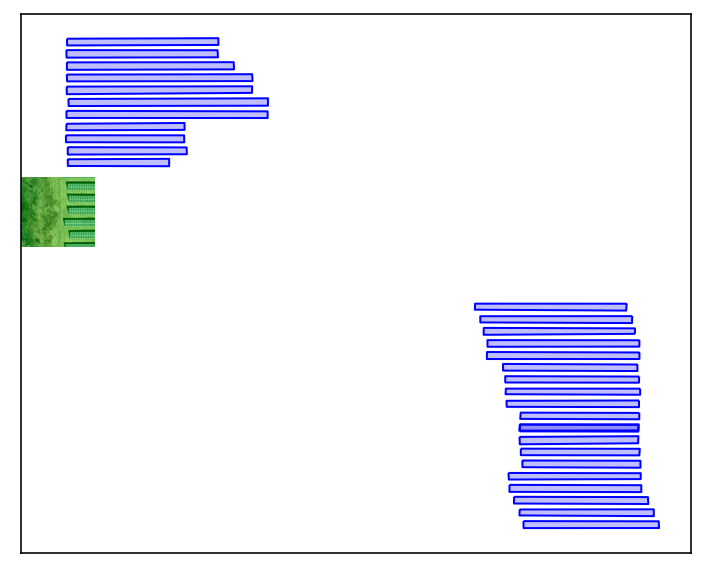

In [9]:
fig, ax = plt.subplots(num='main', figsize=(6,6))

# %%
# Plot the image transforming the coordinates from pixel coordinates to EPSG6434 coordinates
# data = rasterio.open('data/images/180700_se.tif')
# show(data.read([1,2,3]).astype('float')/65536, transform=data.transform, ax=ax)
data = rasterio.open('data/images/cropped.tif')
show(data.read([1,2,3]).astype('float')/255, transform=data.transform, ax=ax)

# %%
# PLOT SEGMENTATION DATA
raw_segmentation = gpd.read_file("data/annotations/segmentation.geojson")
segmentation = raw_segmentation.to_crs(epsg=6434).copy()
segmentation = segmentation.assign(label=0) # Sets default label to 0
# Convert Other, TP, FP, and FN to numerical values
for (i, entry) in enumerate(segmentation.iterrows()):
    if entry[1].default == 'TP':
        segmentation.at[i,'label'] = 1
    elif entry[1].default == 'FP':
        segmentation.at[i,'label'] = 2
    elif entry[1].default == 'FN':
        segmentation.at[i,'label'] = 3
# segmentation.plot(ax=ax, linewidth=1, ec=(0,0,1,1), fc=(0,0,1,0.25))

# Need to feed in pairs of geometries and the corresponding values to use
shapes = []
for (i, entry) in enumerate(segmentation.iterrows()):
    shapes.append((segmentation.at[i,'geometry'], segmentation.at[i,'label']))


result = rasterize(shapes,out_shape=data.shape, transform=data.transform)
masked_labels = np.ma.masked_where(result == 0, result)
colors = [
          (0.01,0.91,0.04),
          (1,0,0),
          (1,0.78,0.2)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', colors, N=len(colors))
show(masked_labels, transform=data.transform, ax=ax, alpha=0.4, cmap=cmap, interpolation='none')

ax.set_xticks([])
ax.set_yticks([])

# Plot manual annotations
raw_annotations = gpd.read_file("data/annotations/annotations.geojson")
annotations = raw_annotations.to_crs(epsg=6434).copy()
annotations.plot(ax=ax, linewidth=1, edgecolor=(0,0,1,1), facecolor=(0,0,1,0.25))

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>